<a href="https://colab.research.google.com/github/john-a-dixon/forecasting-food-sales/blob/main/forecasting-food-sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _**Forecasting Food Sales**_

###### **by John Andrew Dixon**

---

## Loading Data

#### *Data Dictionary*

|**Variable Name**        |**Description**                                                                                    |
|-------------------------|---------------------------------------------------------------------------------------------------|
|Item_Identifier          |Unique Product ID                                                                                  |
|Item_Weight              | Weight of product                                                                                 |
|Item_Fat_Content         |Whether the product is low fat or regular                                                          |
|Item_Visibility          |The percentage of total display area of all products in a store allocated to the particular product|
|Item_Type                |The category to which the product belongs                                                          |
|Item_MRP                 |Maximum Retail Price (list price) of the product                                                   |
|Outlet_Identifier        |Unique store ID                                                                                    |
|Outlet_Establishment_Year|The year in which the store was established                                                        |
|Outlet_Size              |	The size of the store in terms of ground area covered                                             |
|Outlet_Location_Type     |The type of area in which the store is located                                                     |
|Outlet_Type              |Whether the outlet is a grocery store or some sort of supermarket                                  |
|Item_Outlet_Sales        |Sales of the product in the particular store. This is the target variable to be predicted          |

#### *Imports & Load*

In [322]:
# Import the Pandas module
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data into a DataFrame
food_sales_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSdSJuFHcoz8G3NZPlYpavtY8IjFJDczqqEukadW_rEfumnbd5kpF9H0e9vS9kxrnglCYiwLJy4_PXK/pub?output=csv')

# Verification
food_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [323]:
# Take a quick look at the data
food_sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Data Cleaning

#### *Inspecting Rows & Columns*

In [324]:
# Output the DataFrame's shape which is the number of rows and columns
rows_columns = food_sales_df.shape
rows_columns

(8523, 12)

> * There are 8523 rows with 12 columns.
#### *Inspecting Column Datatypes*

In [325]:
# Output the DataFrame's columns' datatypes

food_sales_df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

> * Based on it's name and Data Dictionary description, the column `Outlet_Size` ought to be a float or int. However, upon inspecting the table's head above, I see that the rows are categorical, *not* numerical. Thus, it's current `object` type makes sense. 
> * All other column datatypes align with what is expected as laid out in the Data Dictionary above.

#### *Inspecting For Duplicates*

In [326]:
# Count the number of duplicates
food_sales_df.duplicated().sum()

0

> * Fortunately, there are no duplicates within the data.

#### *Inspecting & Correcting Categorical Value Inconsistencies*

###### _Handling missing data comes after this._ 

In [327]:
# Loop through columns with categorical data and output their value counts
for column in food_sales_df.columns:
    if food_sales_df[column].dtype == 'object':
        print('***************************************************')
        print(column.upper())
        print(food_sales_df[column].value_counts())
        print()

***************************************************
ITEM_IDENTIFIER
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

***************************************************
ITEM_FAT_CONTENT
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

***************************************************
ITEM_TYPE
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dty

> * Only the `Item_Fat_Content` column appears to contain inconsistences:
>   1. The label `Low Fat` is also entered as `LF` and `low fat`
>   2. The label `Regular` is also entered as `reg`
> * I will now fix the inconsistencies of the `Item_Fat_Content` column:

In [328]:
# Create a replacement dictionary specifying the proper replacements
replacement_dict = {
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
}

# Apply the replacement dictionary inpace
food_sales_df['Item_Fat_Content'].replace(replacement_dict, inplace=True)

# Verify
food_sales_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

#### _Identifying Missing Values_

In [329]:
# Ouput the number of missing values for each column
missing_data_count = food_sales_df.isna().sum()
missing_data_count

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [330]:
# Calculate the percent of data missing in the Item_Weight column
missing_item_weight_perc = missing_data_count['Item_Weight'] / len(food_sales_df)
missing_item_weight_perc

0.1716531737651062

In [331]:
# Calculate the percent of data missing in the Outlet_Size column
missing_outlet_size_perc = missing_data_count['Outlet_Size'] / len(food_sales_df)
missing_outlet_size_perc

0.2827642848762173

> * About 17.165% of rows have a missing value within the `Item_Weight` column.
> * About 28.276% of rows have a missing value within the `Outlet_Size` column.

#### _Handling Missing Values_
> * The percentages of missing values are too high to delete the corresponding rows. Likewise, I do not yet know whether these two columns are pertinent to the problem I am trying to solve, so I cannot delete the columns. So, I will fill in their values.
> * First, I'll handle the missing values for the `Item_Weight` column. To start, note that some values in the `Item_Identifier` column repeat across rows:

In [332]:
# Count the number of times a value occurs within the Item_Identifier column
food_sales_df['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

> * I’ll use the top three `Item_Identifier` values above (FDW13, FDG33, NCY18) as a sample and show their corresponding rows:

In [333]:
# Create three filters to select the sampled Item_Identifiers
fdw13 = food_sales_df['Item_Identifier'] == 'FDW13'
fdg33 = food_sales_df['Item_Identifier'] == 'FDG33'
ncy18 = food_sales_df['Item_Identifier'] == 'NCY18'

# Apply the filters and sort the resulting DataFrame by Item_Identifier
food_sales_df.loc[fdw13 | fdg33 | ncy18, :].sort_values(by='Item_Identifier')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
231,FDG33,NaN,Regular,0.139561,Seafood,170.4764,OUT027,1985,Medium,Tier 3,Supermarket Type3,3435.5280
7726,FDG33,5.365,Regular,0.140214,Seafood,173.7764,OUT035,2004,Small,Tier 2,Supermarket Type1,4637.9628
7098,FDG33,5.365,Regular,0.140124,Seafood,172.0764,OUT013,1987,High,Tier 3,Supermarket Type1,2748.4224
7011,FDG33,5.365,Regular,0.140812,Seafood,173.5764,OUT018,2009,Medium,Tier 3,Supermarket Type2,2061.3168
1202,FDG33,5.365,Regular,0.140525,Seafood,172.7764,OUT045,2002,NaN,Tier 2,Supermarket Type1,2233.0932
1575,FDG33,NaN,Regular,0.245543,Seafood,172.2764,OUT019,1985,Small,Tier 1,Grocery Store,171.7764
6112,FDG33,5.365,Regular,0.141034,Seafood,173.6764,OUT017,2007,NaN,Tier 2,Supermarket Type1,858.8820
5164,FDG33,5.365,Regular,0.140240,Seafood,171.0764,OUT046,1997,Small,Tier 1,Supermarket Type1,3263.7516
2728,FDG33,5.365,Regular,0.234733,Seafood,173.4764,OUT010,1998,NaN,Tier 3,Grocery Store,171.7764
4747,FDG33,5.365,Regular,0.140458,Seafood,169.7764,OUT049,1999,Medium,Tier 1,Supermarket Type1,3263.7516


> * Notice the following:
>   1. A repeating value in the `Item_Identifier` column references an item that is present in different stores (e.g. A group of rows have an `Item_Identifier` of FDG33 but one  has an `Outlet_Identifier` of OUT027 and another has an `Outlet_Identifier` of OUT035 and so on).
>   2. For each row with the same `Item_Identifier` value, it appears as if the values in the `Item_Weight` column are the same, except for when there's a missing value (e.g. All rows with `Item_Identifier` FDG33 have the same `Item_Weight` of 5.365 except for when they are missing data). I can verify if this is true for every row with the same `Item_Identifier` value through a few operations in Pandas (in-depth explanation in Python comments below):

In [334]:
# 1. Create a DataFrame of Item_Weight values grouped by Item_Identifier.
# 2. Ignoring missing values, get the number of distinct Item_Weight values per Item_Identifier.
unique_item_weights = food_sales_df.groupby('Item_Identifier')[['Item_Weight']].nunique()

# 3. Use an elementwise boolean comparison on the DataFrame to verify whether the number of Item_Weight 
#    values per Item_Identifier values is only 1. I say only 1 because I want to verify if each row with 
#    the same Item_Identifier has the same Item_Weight (aka, only one weight per Item_Identifier) 
# 4. The returned DataFrame has the Item_Identifier values in one column and whether or 
#    not they have only one Item_Weight (excluding missing values) in another column
unique_item_weights =  unique_item_weights == 1

# 5. Perform an elementwise not on all the elements of the DataFrame produced previously (above).
# 6. Use .any to verify whether any element is True within the Series. (A True element would have 
#    been False before, and if False before then that would mean there exists an Item_Identifier 
#    for which there are more than one Item_Weight values, excluding missing values. This will return 
#    True below. But it doesn't.)
#    I found out about .any while scouring the Pandas documentation:
#    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.any.html
~unique_item_weights['Item_Weight'].any()

False

> * Based on the output above, I can now say that rows with the same `Item_Identifier` value have the same `Item_Weight` value, unless they have missing values. This implies that all items of the same `Item_Identifier` should/do have the same `Item_Weight`. So, I will make rows with the same `Item_Identifier` values have all the same `Item_Weight` values to account for the missing data. First, I'll once again group the `Item_Weight` values by the `Item_Identifier` values and select the first non-missing `Item_Weight` value:

In [335]:
# Excluding the missing values, count the  prices of each item/Item_Identifier, excluding rows with NaN.
# I used this pages on Pandas GroupBy to discover the .first method:
# https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html
item_weight_by_item_identifier = food_sales_df.groupby('Item_Identifier')['Item_Weight'].first()
item_weight_by_item_identifier

Item_Identifier
DRA12    11.600
DRA24    19.350
DRA59     8.270
DRB01     7.390
DRB13     6.115
          ...  
NCZ30     6.590
NCZ41    19.850
NCZ42    10.500
NCZ53     9.600
NCZ54    14.650
Name: Item_Weight, Length: 1559, dtype: float64

> * Then, I'll replace each missing value in the `Item_Weight` column with the first non-missing `Item_Weight` value of its corresponding `Item_Identifier` value (e.g. Replace the missing `Item_Weight` values of rows with `Item_Identifier` FDG33 with the first occuring `Item_Weight` of all rows with `Item_Identifier` FDG33):

In [336]:
# Filter to target only values in the Item_Weight column that are missing
is_NaN_filter = pd.isna(food_sales_df['Item_Weight']) 

# Go through and fill in the missing data
for identifier in item_weight_by_item_identifier.index:
    # Filter to target all rows with a specific Item_Identifier
    item_identifier_filter = food_sales_df['Item_Identifier'] == identifier

    # Gets the current Item_Identifiers average weight
    item_weight = item_weight_by_item_identifier[identifier]

    # Change the missing values to the average weight based on the current
    # Item_Identifier and whether there is missing data
    # This stack overflow post helped me figure out how to change values in one column
    # Based on row values
    # https://stackoverflow.com/questions/53598233/pandas-replace-values-condition-based-on-another-column
    food_sales_df.loc[is_NaN_filter & item_identifier_filter, 'Item_Weight'] = item_weight

> * Finally, I'll verify how well this process filled in the missing values of the `Item_Weight` column:

In [337]:
# On the Item_Weight column, identify how many values are missing
food_sales_df['Item_Weight'].isna().sum()

4

> * There are still 4 rows out of 8523 with missing data on the `Item_Weight` column. I'll remove them since losing 4 rows out of 8523 presents a negligible impact:

In [338]:
# Remove all rows where there is missing data in the Item_Weight column
food_sales_df.dropna(subset=['Item_Weight'], inplace=True)

# On the Item_Weight column, identify how many values are missing
food_sales_df['Item_Weight'].isna().sum()

0

> * There are no more missing values in the `Item_Weight` column.
> * Handling the missing values within the `Outlet_Size` column will be different because it is a column with categorical values, not numerical. To start, I want to group the `Outlet_Size` column by the `Outlet_Identifier` column to see the relative sizes of each outlet:


In [339]:
# Show the Outlize_Size based on Outlet_Identifiers
food_sales_df.groupby('Outlet_Identifier')['Outlet_Size'].value_counts(dropna=False)

Outlet_Identifier  Outlet_Size
OUT010             NaN            555
OUT013             High           932
OUT017             NaN            926
OUT018             Medium         928
OUT019             Small          527
OUT027             Medium         932
OUT035             Small          930
OUT045             NaN            929
OUT046             Small          930
OUT049             Medium         930
Name: Outlet_Size, dtype: int64

> * Based on the output, it’s apparent that all rows with the same `Outlet_Identifier` have the same `Outlet_Size`. 
> * It also appears that rows with an `Outlet_Identifier` of OUT010, OUT017, and OUT045 are all missing sizes. That is, rows that have one of these three values in their `Outlet_Identifier` column do not have _**any**_ data in the `Outlet_Size` column. 
> * I will try to discern a pattern within the available data that’ll help me make an informed judgment on how to fill in the missing values in the `Outlet_Size` column. If there is no apparent pattern, I’ll simply fill the missing values with the most common `Outlet_Size` value (its mode, since this column is categorical) or label the missing values as 'Unknown'. 
>* Based on the descriptions of each column in the Data Dictionary, I chose columns that may have an impact on `Outlet_Size` and used them with **`.groupby`** to hopefully discern some patterns:


In [340]:
# Group the Outlet_Size by the Outlet_Type, include missing values
food_sales_df.groupby(['Outlet_Type'])['Outlet_Size'].value_counts(dropna=False, ascending=True)

Outlet_Type        Outlet_Size
Grocery Store      Small           527
                   NaN             555
Supermarket Type1  Medium          930
                   High            932
                   NaN            1855
                   Small          1860
Supermarket Type2  Medium          928
Supermarket Type3  Medium          932
Name: Outlet_Size, dtype: int64

In [341]:
# Group the Outlet_Size by Outlet_Location_Type, include missing values
food_sales_df.groupby(['Outlet_Location_Type'])['Outlet_Size'].value_counts(dropna=False, ascending=True)

Outlet_Location_Type  Outlet_Size
Tier 1                Medium          930
                      Small          1457
Tier 2                Small           930
                      NaN            1855
Tier 3                NaN             555
                      High            932
                      Medium         1860
Name: Outlet_Size, dtype: int64

In [342]:
# Group Outlet_Size by Outlet_Establishment_Year, include missing values
food_sales_df.groupby(['Outlet_Establishment_Year'])['Outlet_Size'].value_counts(dropna=False, ascending=True)

Outlet_Establishment_Year  Outlet_Size
1985                       Small          527
                           Medium         932
1987                       High           932
1997                       Small          930
1998                       NaN            555
1999                       Medium         930
2002                       NaN            929
2004                       Small          930
2007                       NaN            926
2009                       Medium         928
Name: Outlet_Size, dtype: int64

In [343]:
# Show the mean sales of the Outlets
food_sales_df.groupby(['Outlet_Identifier', 'Outlet_Size'], dropna=False)[['Item_Outlet_Sales']].sum()

,,Item_Outlet_Sales
Outlet_Identifier,Outlet_Size,
OUT010,NaN,1.883402e+05
OUT013,High,2.142664e+06
OUT017,NaN,2.167465e+06
OUT018,Medium,1.851823e+06
OUT019,Small,1.795736e+05
OUT027,Medium,3.444468e+06
OUT035,Small,2.268123e+06
OUT045,NaN,2.036725e+06
OUT046,Small,2.118395e+06


In [344]:
# Output the most common size
food_sales_df['Outlet_Size'].value_counts(dropna=False)

Medium    2790
NaN       2410
Small     2387
High       932
Name: Outlet_Size, dtype: int64

> * Based on the various outputs above, there appears to be a pattern:
>   1. All rows that are labeled `Grocery Store` within the `Outlet_Type` column are either `Small` or `NaN` on the `Outlet_Size` column. Because of this, I believe it makes sense to change these `NaN` values to `Small`.
>   2. All rows that are labeled `Tier 2` within the `Outlet_Location_Type` column are either `Small` or `NaN` on the `Outlet_Size` column. Because of this, I believe it makes sense to change these `NaN` values to `Small`.
> * Though these patterns may be tenuous, I believe it is better and more well-informed than simply blindly filling in all the missing values with the most common occurence (Medium) without any reason except that it is the most common. Besides, there is only a 403 count different between the amount of times Medium and Small occur. If Medium appeared double the amount of times Small appeared I'd be more likely to change the missing values to Medium. Additionally, I believe using these patterns is better than assigning the missing values 'Unknown' since assigning them 'Unknown' adds a whole new category to the `Outlet_Size` column that was not in the original data. If no patterns were discerned, and the occurence counts were the same as they are now, I'd add `Unknown` as a new category.

In [345]:
# Replace all missing values in the Outlet_Size column with small
# for where the row has an Outlet_Type of Grocery_Store
food_sales_df.loc[food_sales_df['Outlet_Type'] == 'Grocery Store', 'Outlet_Size'] = 'Small'

# Replace all missing values in the Outlet_Size column with small
# for where the row has an Outlet_Type of Grocery_Store
food_sales_df.loc[food_sales_df['Outlet_Location_Type'] == 'Tier 2', 'Outlet_Size'] = 'Small'

display(food_sales_df['Outlet_Size'].value_counts(dropna=False))
food_sales_df.isna().sum()

Small     4797
Medium    2790
High       932
Name: Outlet_Size, dtype: int64

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

> * No more missing values persist.

#### _Summary Statistics_

In [346]:
# Show summary stats for numerical columns
food_sales_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


> * It's worth noting that the mininum `Item_Visibility` value is 0, meaning there are rows that correspond to items in a store that have _**no**_ visibility. This is odd. However, I won't do anything about this just yet, since I currently do not know what I will be doing with the data.

## Exploratory Visuals

#### _Exploring Numerical Feature Distributions_

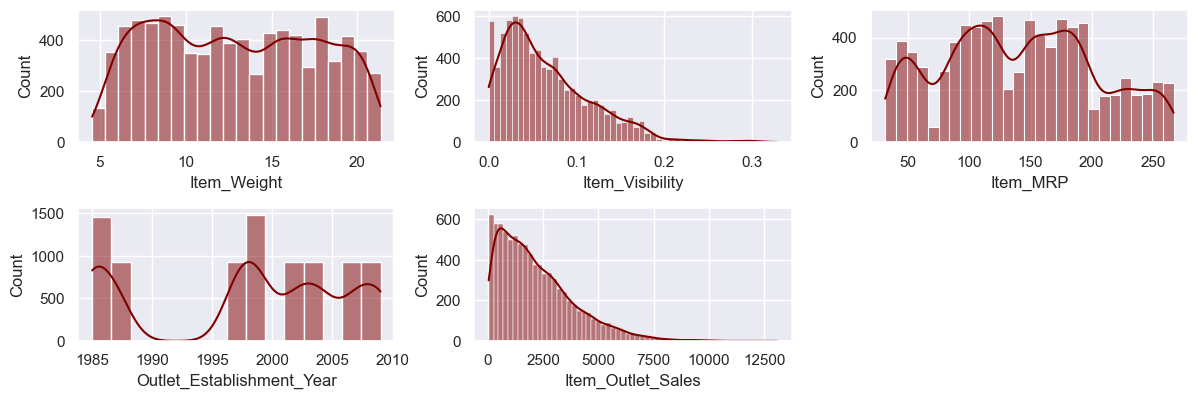

In [347]:
# Create multiple plots
# Aside from the class readings, I used the following to help me do this:
# https://www.statology.org/seaborn-subplots/
# Set default Seaborn aesthetics
sns.set()

# Using Matplotlib, define plotting regions (3 rows, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 4))

# Fix tight layout. I used the following to help me do this:
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots
fig.tight_layout()

# Delete extra subplot. I used the following to help
# https://stackoverflow.com/questions/44980658/remove-the-extra-plot-in-the-matplotlib-subplot
fig.delaxes(axes[1, 2])

# Further adjust the padding between subplots. I used the following for help: 
# https://stackoverflow.com/questions/43970609/how-to-adjust-space-between-matplotlib-seaborn-subplots-for-multi-plot-layouts
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
plt.subplots_adjust(hspace=0.5, wspace=0.25)

# Create the plots
sns.histplot(data=food_sales_df, x='Item_Weight', ax=axes[0, 0], kde=True, color='Maroon')
sns.histplot(data=food_sales_df, x='Item_Visibility', ax=axes[0, 1], kde=True, color='Maroon')
sns.histplot(data=food_sales_df, x='Item_MRP', ax=axes[0, 2], kde=True, color='Maroon')
sns.histplot(data=food_sales_df, x='Outlet_Establishment_Year', ax=axes[1, 0], kde=True, color='Maroon')
sns.histplot(data=food_sales_df, x='Item_Outlet_Sales', ax=axes[1, 1], kde=True, color='Maroon');


Two histograms immediately stand out. I'll recreate those two with their respective boxplots:

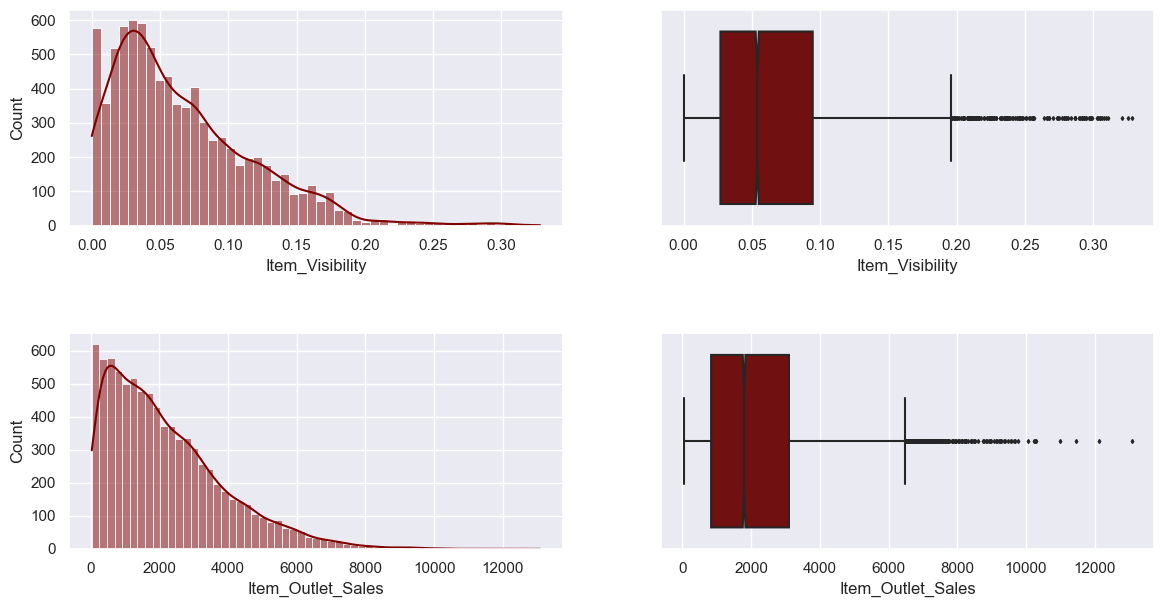

In [348]:
# Using Matplotlib, define plotting regions (1 row, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))

# Further adjust the padding between subplots. I used the following for help: 
plt.subplots_adjust(hspace=0.5)

# Create the plots
sns.histplot(data=food_sales_df, x='Item_Visibility', ax=axes[0, 0], kde=True, color='Maroon')
sns.boxplot(data=food_sales_df, x='Item_Visibility', ax=axes[0, 1], notch=True, color='Maroon', fliersize=2)
sns.histplot(data=food_sales_df, x='Item_Outlet_Sales', ax=axes[1, 0], kde=True, color='Maroon')
sns.boxplot(data=food_sales_df, x='Item_Outlet_Sales', ax=axes[1, 1], notch=True, color='Maroon', fliersize=2);

In [349]:
# https://www.geeksforgeeks.org/how-to-use-pandas-filter-with-iqr/
item_outlet_sales_IQR = np.quantile(food_sales_df['Item_Outlet_Sales'], 0.75) - np.quantile(food_sales_df['Item_Outlet_Sales'], 0.25)
item_visibility_sales_IQR = np.quantile(food_sales_df['Item_Visibility'], 0.75) - np.quantile(food_sales_df['Item_Visibility'], 0.25)
display(f'Item_Outlet_Sales IQR: {item_outlet_sales_IQR}')
display(item_visibility_sales_IQR)
food_sales_df[['Item_Outlet_Sales', 'Item_Visibility']].describe().round(3)

'Item_Outlet_Sales IQR: 2266.3832'

0.0675748815

,Item_Outlet_Sales,Item_Visibility
count,8519.000,8519.000
mean,2181.189,0.066
std,1706.511,0.052
min,33.290,0.000
25%,834.247,0.027
50%,1794.331,0.054
75%,3100.631,0.095
max,13086.965,0.328


These two histograms show the following:

- The features `Item_Outlet_Sale` and `Item_Outlet_Sales` are skewed right.
- Each has a significant number of outliers, further skewing the data right.

A box plot and summary statistics can best describe the distribution in these two features. Based on the output above, the following can be said:

- For `Item_Outlet_Sale` the median is $1794.33 and 50% of the values reported are between $834.25 and $3100.63. This means `Item_Outlet_Sales` varies moderately per entry.
- For `Item_Visibility` the median is 0.054 (5.4%) and 50% of the values reported are between 0.027 (2.7%) and 0.095 (9.5%). This means `Item_Visibility` varies moderately per entry as well.

#### _Exploring Relationships Between Features_

How does `Item_Fat_Content` affect `Item_Outlet_Sales`?:

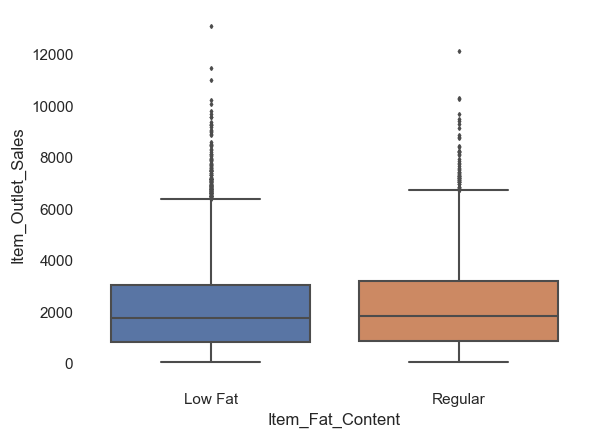

In [360]:
# Create a boxplot showing how sales are influenced by fat content
sns.boxplot(data=food_sales_df, x='Item_Fat_Content', y='Item_Outlet_Sales', fliersize=2);

In [362]:
# Summary statistics for the boxplots above
food_sales_df.groupby('Item_Fat_Content')['Item_Outlet_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Item_Fat_Content,,,,,,,,
Low Fat,5516.0,2157.298823,1697.850994,33.2900,825.9249,1765.0358,3049.19755,13086.9648
Regular,3003.0,2225.070565,1721.725035,33.9558,857.5504,1844.9318,3198.17030,12117.5600


Regular food items tend to bring in more sales, though not by much. 

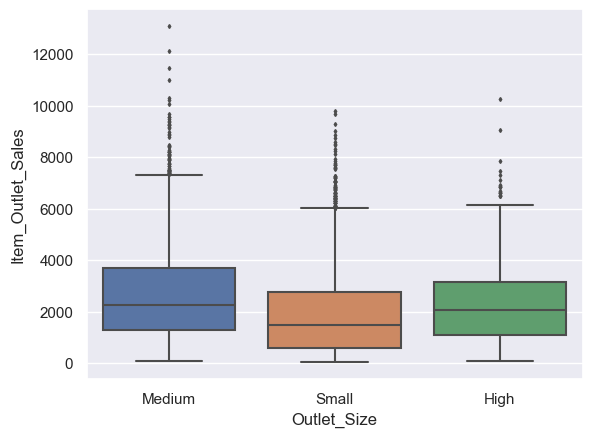

In [351]:
# Create a boxplot showing how sales are influenced by fat content
sns.boxplot(data=food_sales_df, x='Outlet_Size', y='Item_Outlet_Sales', fliersize=2);

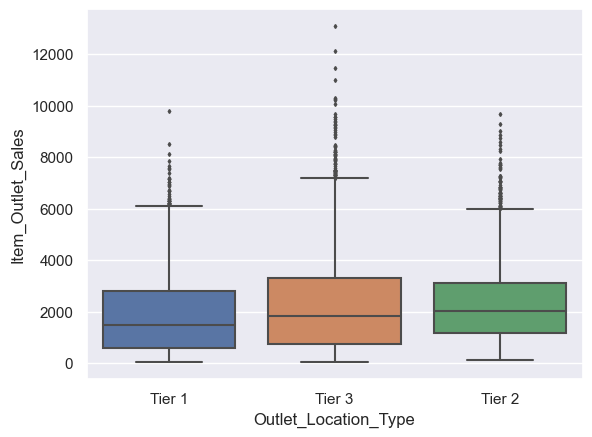

In [352]:
# Create a boxplot showing how sales are influenced by fat content
sns.boxplot(data=food_sales_df, x='Outlet_Location_Type', y='Item_Outlet_Sales', fliersize=2);

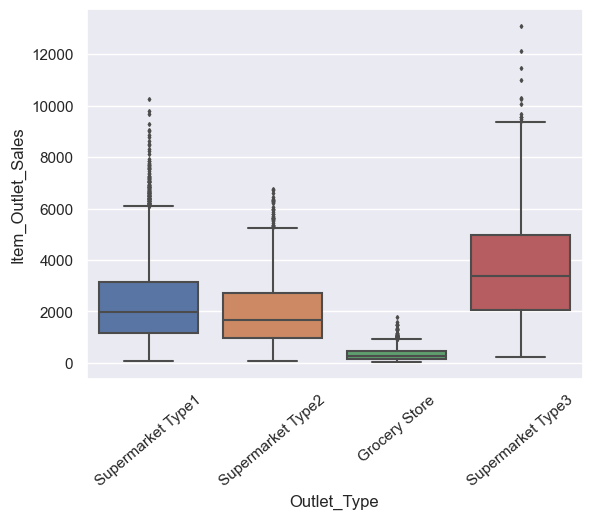

In [353]:
# Create a boxplot showing how sales are influenced by fat content
ax = sns.boxplot(data=food_sales_df, x='Outlet_Type', y='Item_Outlet_Sales', fliersize=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40);

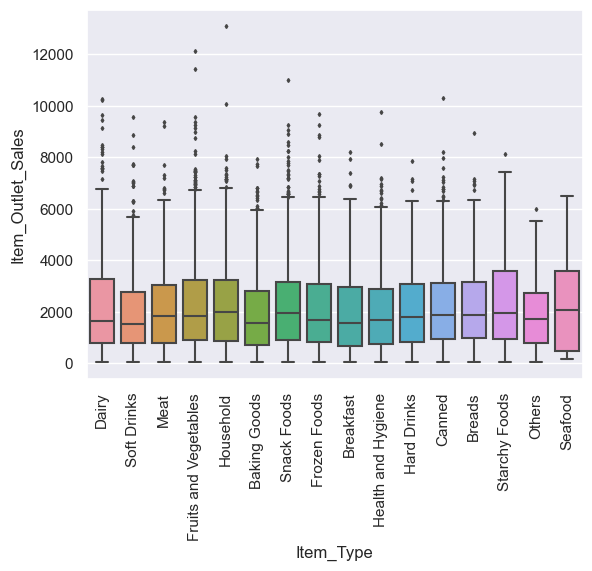

In [354]:
# Create a boxplot showing how sales are influenced by fat content
ax = sns.boxplot(data=food_sales_df, x='Item_Type', y='Item_Outlet_Sales', fliersize=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

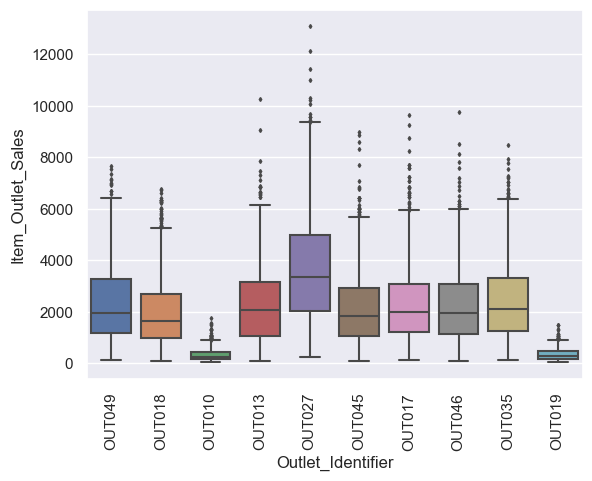

In [355]:
# Create a boxplot showing how sales are influenced by fat content
ax = sns.boxplot(data=food_sales_df, x='Outlet_Identifier', y='Item_Outlet_Sales', fliersize=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

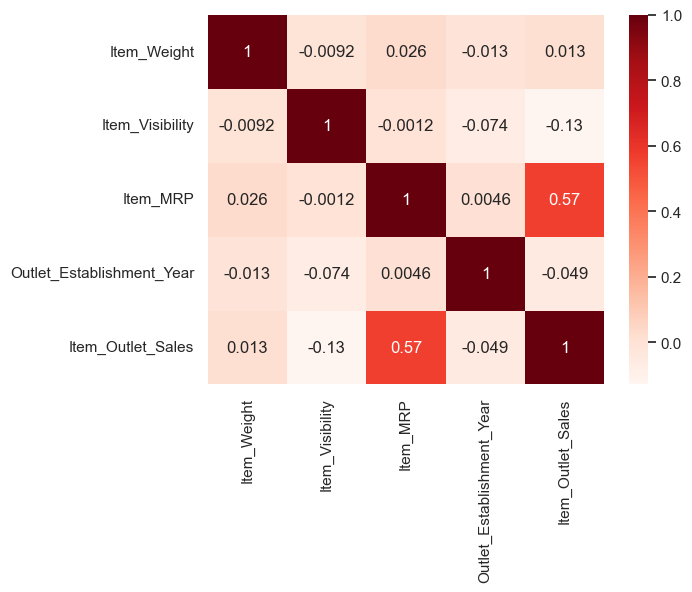

In [356]:
correlations = food_sales_df.corr(numeric_only=True)
sns.heatmap(correlations, cmap='Reds', annot=True);

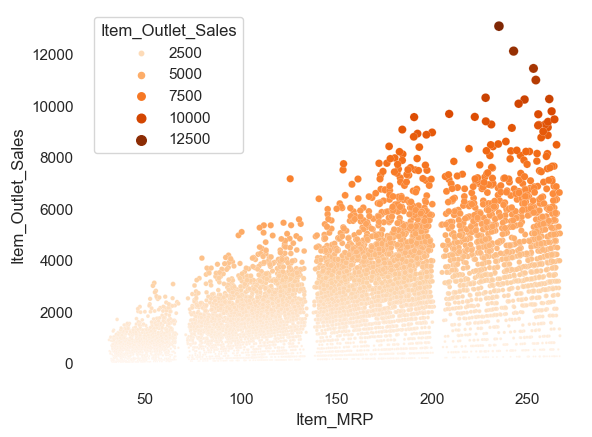

In [357]:
# I used the following to help me make a Seaborn scatterplot:
# https://www.geeksforgeeks.org/scatterplot-using-seaborn-in-python/
# https://www.statology.org/seaborn-scatterplot-marker-size/
# https://towardsdatascience.com/cool-scatter-plots-dfb23bebb3dc
# https://www.statology.org/seaborn-background-color/
sns.set(rc={'axes.facecolor':'white'});
sns.scatterplot(data=food_sales_df, 
                x ='Item_MRP', 
                y ='Item_Outlet_Sales', 
                size='Item_Outlet_Sales',
                sizes=(1, 50),
                palette='Oranges', 
                hue='Item_Outlet_Sales');

## Explanatory Visuals